In [1]:
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import get_dataset_df_from_file as get_world_dataset_df_from_file

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch data set from local disk

In [4]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-04-01_1652_state_daily_data.csv 2020-04-01_1658_state_rank.csv
2020-04-01_1652_state_rank.csv       2020-04-03_0323_state_daily_data.csv
2020-04-01_1654_state_daily_data.csv 2020-04-03_0323_state_rank.csv
2020-04-01_1654_state_rank.csv       2020-04-03_0345_state_daily_data.csv
2020-04-01_1658_state_daily_data.csv 2020-04-03_0345_state_rank.csv
Latest files are:
	/Users/drskippy/data/2020-04-03_0345_state_daily_data.csv
	/Users/drskippy/data/2020-04-03_0345_state_rank.csv


In [5]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,order,lastUpdateEt
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,NaN,NaN,NaN,...,54,54,36,NaN,NaN,NaN,NaN,NaN,0,2020-04-02 11:45:00
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,NaN,NaN,NaN,...,98,98,36,0.0,0.0,28.0,16.0,44.0,0,2020-04-02 11:45:00
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,125,125,36,0.0,0.0,16.0,11.0,27.0,0,2020-04-02 11:45:00
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,168,168,36,0.0,0.0,0.0,43.0,43.0,0,2020-04-02 11:45:00
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,...,197,197,36,0.0,0.0,0.0,29.0,29.0,0,2020-04-02 11:45:00


### SIR Model

In [6]:
dfq, _ = get_state_df(df, "*")
pos_untested = 0.8
dfq["actual_pos"] = dfq.positive.values*(1 + pos_untested)/1000
dfq.head()

,date,positive,negative,pending,totalTestResults,death,lastUpdateEt,daily_new_positive,actual_pos
0,2020-03-04,118.0,748.0,103.0,866,10.0,2020-04-02 16:45:00,NaN,0.2124
1,2020-03-05,176.0,953.0,197.0,1129,11.0,2020-04-02 16:45:00,58.0,0.3168
2,2020-03-06,223.0,1571.0,458.0,1794,14.0,2020-04-02 16:45:00,47.0,0.4014
3,2020-03-07,341.0,1809.0,602.0,2150,16.0,2020-04-02 16:45:00,118.0,0.6138
4,2020-03-08,417.0,2335.0,347.0,2752,18.0,2020-04-02 16:45:00,76.0,0.7506


### SIR Fit

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 1.09464158e-03,  6.17182877e-03,  1.14970596e-01],
       [-6.96366051e-04,  1.36799632e-06,  6.18505347e-05],
       [ 1.29786523e-03,  2.83001045e-03,  5.35269910e-02]])
     fun: 4867.04040365632
 message: 'Optimization terminated successfully.'
    nfev: 743
     nit: 19
  status: 0
 success: True
       x: array([0.34173782, 0.17080818, 1.56664179])
Doubling time is about 2.03 days
Recovery time is about 4.06 days
Estimated initial infection was order of 1,566 poeple


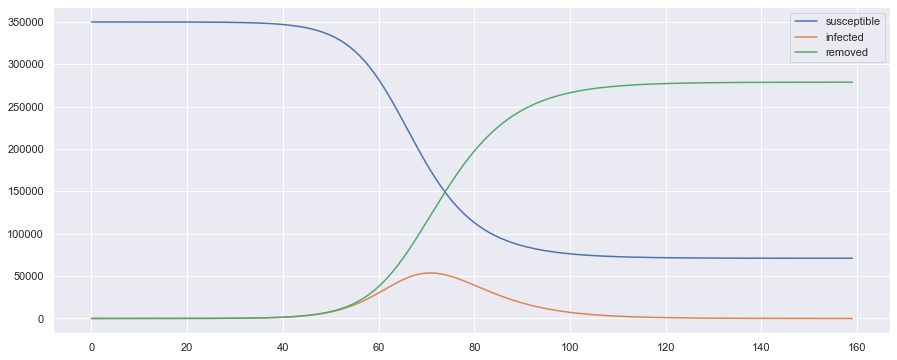

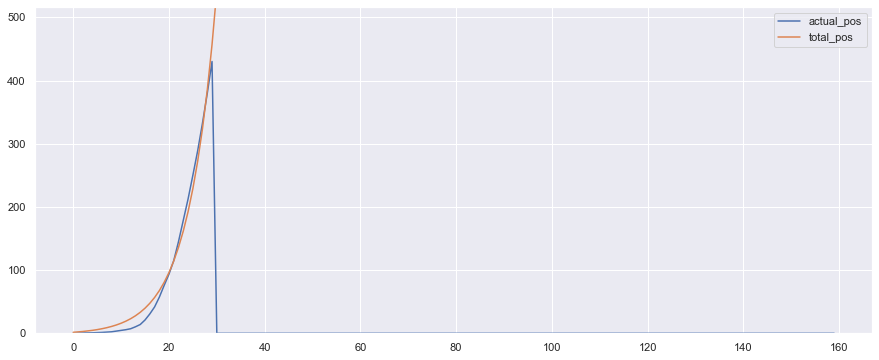

In [7]:
N=350000 
R0=0
x0 = (0.3896, 0.08149, 0.1)
c = dfq.actual_pos.values
beta, gamma, I0 = SIRFitter(c, N, x0)
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

In [8]:
dfw, wsl = get_world_dataset_df_from_file()
dfw.head()

,Entity,state,Date,positive,date,lastUpdateEt,negative,pending
0,Afghanistan,AFG,"Dec 31, 2019",0,2019-12-31,2020-04-03 03:45:50.732824,0,0
1,Afghanistan,AFG,"Jan 1, 2020",0,2020-01-01,2020-04-03 03:45:50.732824,0,0
2,Afghanistan,AFG,"Jan 2, 2020",0,2020-01-02,2020-04-03 03:45:50.732824,0,0
3,Afghanistan,AFG,"Jan 3, 2020",0,2020-01-03,2020-04-03 03:45:50.732824,0,0
4,Afghanistan,AFG,"Jan 4, 2020",0,2020-01-04,2020-04-03 03:45:50.732824,0,0


/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 5.35525760e-04, -7.07713229e-04, -2.79716685e-02],
       [ 6.55304779e-03, -5.94497108e-03, -4.35491764e-01],
       [ 7.42331358e-04, -3.34371190e-04, -1.47852621e-02]])
     fun: 5069.5696759168195
 message: 'Optimization terminated successfully.'
    nfev: 357
     nit: 8
  status: 0
 success: True
       x: array([0.2269768 , 0.13508859, 0.2994105 ])
Doubling time is about 3.05 days
Recovery time is about 5.13 days
Estimated initial infection was order of 299 poeple


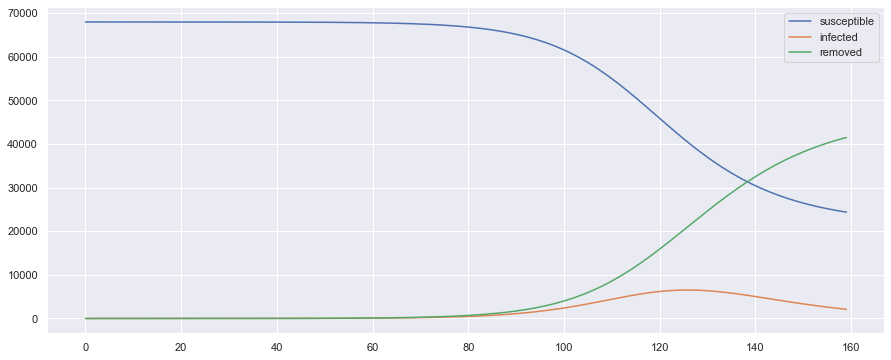

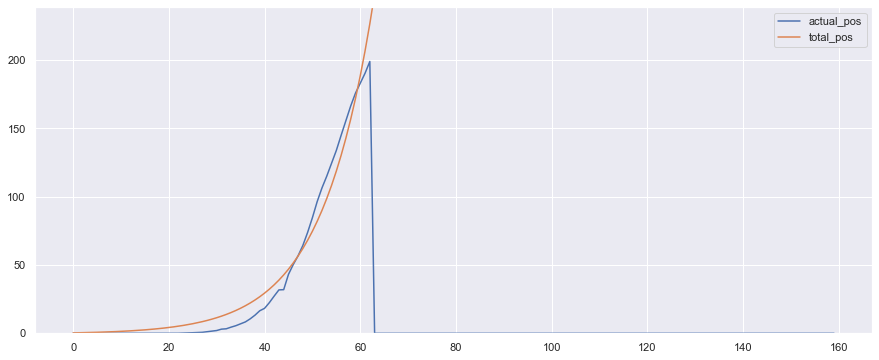

In [9]:
dfq, _ = get_state_df(dfw, "ITA")
pos_untested = 0.8
dfq["actual_pos"] = dfq.positive.values*(1 + pos_untested)/1000
N=68000 
R0=0
x0 = (0.33989521, 0.14846294, 1.09806025)
c = np.trim_zeros(dfq.actual_pos.values)
beta, gamma, I0 = SIRFitter(c, N, x0)
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 0.00014475, -0.00019573, -0.00085159],
       [ 0.00528153, -0.00479703, -0.03998829],
       [ 0.00095622, -0.00057958, -0.00266196]])
     fun: 1650.1996245932546
 message: 'Optimization terminated successfully.'
    nfev: 362
     nit: 8
  status: 0
 success: True
       x: array([0.20595015, 0.07019119, 0.03204354])
Doubling time is about 3.37 days
Recovery time is about 9.88 days
Estimated initial infection was order of 32 poeple


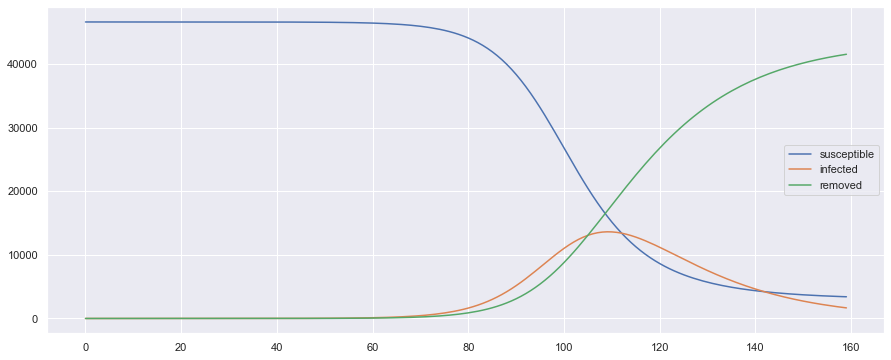

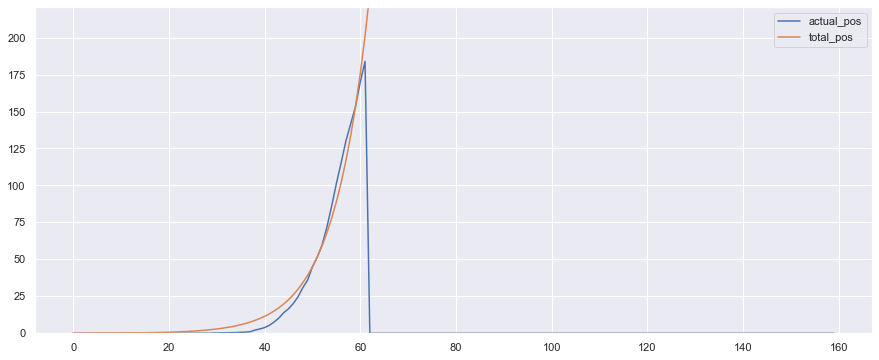

In [10]:
dfq, _ = get_state_df(dfw, "ESP")
pos_untested = 0.8
dfq["actual_pos"] = dfq.positive.values*(1 + pos_untested)/1000
N=46660 
R0=0
x0 = (0.3896, 0.08149, 0.1)
c = np.trim_zeros(dfq.actual_pos.values)
beta, gamma, I0 = SIRFitter(c, N, x0)
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))